In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from imblearn.over_sampling import SMOTE
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
part1 = pd.read_csv("telecom_churn_data-part-1.csv")

part2 = pd.read_csv("telecom_churn_data-part-2.csv")

part3 = pd.read_csv("telecom_churn_data-part-3.csv")

part4 = pd.read_csv("telecom_churn_data-part-4.csv")

part5 = pd.read_csv("telecom_churn_data-part-5.csv")

In [3]:
data = pd.concat([part1, part2, part3, part4, part5])
data.reset_index(drop=True, inplace=True)

data.head()

,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,109,0.0,0.0,0.0,2014-06-30,2014-07-31,2014-08-31,2014-09-30,197.385,214.816,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,109,0.0,0.0,0.0,2014-06-30,2014-07-31,2014-08-31,2014-09-30,34.047,355.074,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,109,0.0,0.0,0.0,2014-06-30,2014-07-31,2014-08-31,2014-09-30,167.690,189.058,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,109,0.0,0.0,0.0,2014-06-30,2014-07-31,2014-08-31,2014-09-30,221.338,251.102,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,109,0.0,0.0,0.0,2014-06-30,2014-07-31,2014-08-31,2014-09-30,261.636,309.876,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 225 entries, circle_id to sep_vbc_3g
dtypes: float64(179), int64(34), object(12)
memory usage: 171.7+ MB


In [5]:
data.shape

(99999, 225)

##### Taking the total recharge amount of 6th and 7th months to filter out the top customer

In [6]:
data['total_rech_amt_6'].isna().sum()

0

In [7]:
data['total_rech_amt_7'].isna().sum()

0

In [8]:
data['total_rech_amt_6&7'] = (data['total_rech_amt_6'] + data['total_rech_amt_7'])/2

In [9]:
data['total_rech_amt_6&7'].quantile([0, 0.25, 0.5, 0.70, 0.9, 1])

0.00        0.0
0.25      115.0
0.50      229.0
0.70      368.5
0.90      698.0
1.00    37762.5
Name: total_rech_amt_6&7, dtype: float64

##### Taking only the customer of high value i.e taking only the customer whose average recharge is more than 70 percentile of the average rechage in 6th and 7th month(i.e. good time)

In [10]:
data = data[data['total_rech_amt_6&7'] >= 368.5]

In [11]:
data = data.reset_index()

In [12]:
data.shape

(30011, 227)

In [13]:
# last_date_of_month_6, last_date_of_month_7, last_date_of_month_8, and last_date_of_month_9 have only single information
# hence droping it
data.drop(['last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'last_date_of_month_9', 'total_rech_amt_6&7']
          , axis=1, inplace=True)

##### Marking the user as churn or not churn who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in month 9th

In [14]:
data[['total_ic_mou_9', 'total_og_mou_9', 'vol_2g_mb_9', 'vol_3g_mb_9']].isna().sum()

total_ic_mou_9    0
total_og_mou_9    0
vol_2g_mb_9       0
vol_3g_mb_9       0
dtype: int64

In [15]:
# 1 if the customer has churned otherwise 0 if not
data['Churn'] = data.apply(lambda row: 0 if ((row.total_ic_mou_9!=0) | (row.total_og_mou_9!=0) | (row.vol_2g_mb_9!=0) | (row.vol_3g_mb_9!=0)) else 1, axis=1)

In [16]:
data.Churn.sum()/len(data)

0.08640165272733331

In [17]:
data.shape

(30011, 223)

##### Droping all the columns for 9th month 

In [18]:
r = re.compile('.*_9')
colOfMonth9 = list(filter(r.match, list(data.columns)))
colOfMonth9

['arpu_9',
 'onnet_mou_9',
 'offnet_mou_9',
 'roam_ic_mou_9',
 'roam_og_mou_9',
 'loc_og_t2t_mou_9',
 'loc_og_t2m_mou_9',
 'loc_og_t2f_mou_9',
 'loc_og_t2c_mou_9',
 'loc_og_mou_9',
 'std_og_t2t_mou_9',
 'std_og_t2m_mou_9',
 'std_og_t2f_mou_9',
 'std_og_t2c_mou_9',
 'std_og_mou_9',
 'isd_og_mou_9',
 'spl_og_mou_9',
 'og_others_9',
 'total_og_mou_9',
 'loc_ic_t2t_mou_9',
 'loc_ic_t2m_mou_9',
 'loc_ic_t2f_mou_9',
 'loc_ic_mou_9',
 'std_ic_t2t_mou_9',
 'std_ic_t2m_mou_9',
 'std_ic_t2f_mou_9',
 'std_ic_t2o_mou_9',
 'std_ic_mou_9',
 'total_ic_mou_9',
 'spl_ic_mou_9',
 'isd_ic_mou_9',
 'ic_others_9',
 'total_rech_num_9',
 'total_rech_amt_9',
 'max_rech_amt_9',
 'date_of_last_rech_9',
 'last_day_rch_amt_9',
 'date_of_last_rech_data_9',
 'total_rech_data_9',
 'max_rech_data_9',
 'count_rech_2g_9',
 'count_rech_3g_9',
 'av_rech_amt_data_9',
 'vol_2g_mb_9',
 'vol_3g_mb_9',
 'arpu_3g_9',
 'arpu_2g_9',
 'night_pck_user_9',
 'monthly_2g_9',
 'sachet_2g_9',
 'monthly_3g_9',
 'sachet_3g_9',
 'fb_user_

In [19]:
data.drop(colOfMonth9, axis=1, inplace=True)

In [20]:
# Checking data
data.head()

,index,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,...,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,Churn
0,7,109,0.0,0.0,0.0,1069.180,1349.850,3171.480,57.84,54.68,...,0,NaN,NaN,NaN,802,57.74,19.38,18.74,0.0,1
1,8,109,0.0,0.0,0.0,378.721,492.223,137.362,413.69,351.03,...,0,NaN,1.0,1.0,315,21.03,910.65,122.16,0.0,0
2,13,109,0.0,0.0,0.0,492.846,205.671,593.260,501.76,108.39,...,0,NaN,NaN,1.0,2607,0.00,0.00,0.00,0.0,0
3,16,109,0.0,0.0,0.0,430.975,299.869,187.894,50.51,74.01,...,0,NaN,NaN,NaN,511,0.00,2.45,21.89,0.0,0
4,17,109,0.0,0.0,0.0,690.008,18.980,25.499,1185.91,9.28,...,0,NaN,NaN,NaN,667,0.00,0.00,0.00,0.0,0


In [21]:
data.drop(['index', 'circle_id', 'sep_vbc_3g'], axis=1, inplace=True)

##### Checking column with high missing values percentage it in

In [22]:
missingCol = (data.loc[:,data.isna().sum()>1000].isna().sum()/len(data)) * 100
missingCol

date_of_last_rech_data_6    62.023925
date_of_last_rech_data_7    61.140915
date_of_last_rech_data_8    60.834361
total_rech_data_6           62.023925
total_rech_data_7           61.140915
total_rech_data_8           60.834361
max_rech_data_6             62.023925
max_rech_data_7             61.140915
max_rech_data_8             60.834361
count_rech_2g_6             62.023925
count_rech_2g_7             61.140915
count_rech_2g_8             60.834361
count_rech_3g_6             62.023925
count_rech_3g_7             61.140915
count_rech_3g_8             60.834361
av_rech_amt_data_6          62.023925
av_rech_amt_data_7          61.140915
av_rech_amt_data_8          60.834361
arpu_3g_6                   62.023925
arpu_3g_7                   61.140915
arpu_3g_8                   60.834361
arpu_2g_6                   62.023925
arpu_2g_7                   61.140915
arpu_2g_8                   60.834361
night_pck_user_6            62.023925
night_pck_user_7            61.140915
night_pck_us

These columns are having high percentage of missing value, hence dropping these columns

In [23]:
data.drop(missingCol.index, axis=1, inplace=True)

#### Checking the columns with high percentage of a single value in it

In [24]:
columns = list(data.columns)
columns.remove('Churn')
len(columns)

136

In [25]:
for col in columns:
    if (data[col].value_counts().iloc[0] > 0) and (data[col].value_counts().iloc[0]/len(data)) > 0.96:
        print("Column "+col+" has more than 96% of single value in it\n")

Column loc_og_t2o_mou has more than 96% of single value in it

Column std_og_t2o_mou has more than 96% of single value in it

Column loc_ic_t2o_mou has more than 96% of single value in it

Column std_og_t2c_mou_6 has more than 96% of single value in it

Column std_og_t2c_mou_7 has more than 96% of single value in it

Column std_og_t2c_mou_8 has more than 96% of single value in it

Column og_others_7 has more than 96% of single value in it

Column og_others_8 has more than 96% of single value in it

Column std_ic_t2o_mou_6 has more than 96% of single value in it

Column std_ic_t2o_mou_7 has more than 96% of single value in it

Column std_ic_t2o_mou_8 has more than 96% of single value in it



In [26]:
data.drop(['loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 
          'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8'], axis=1, inplace=True)

In [27]:
data[['sachet_2g_6', 'sachet_2g_7', 'sachet_2g_6', 'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_6']].describe()

,sachet_2g_6,sachet_2g_7,sachet_2g_6,sachet_3g_6,sachet_3g_7,sachet_3g_6
count,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000
mean,0.500383,0.587185,0.500383,0.137916,0.150212,0.137916
std,1.699665,1.900461,1.699665,0.875528,0.969286,0.875528
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,39.000000,48.000000,39.000000,29.000000,35.000000,29.000000


Merging scahet of 2g and 3g since it's the internet data

In [28]:
data['sachet_2g&3g_6'] = data['sachet_2g_6'] + data['sachet_3g_6']
data['sachet_2g&3g_7'] = data['sachet_2g_7'] + data['sachet_3g_7']
data['sachet_2g&3g_8'] = data['sachet_2g_8'] + data['sachet_3g_8']

In [29]:
data.drop(['sachet_2g_6','sachet_2g_7','sachet_2g_8','sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8'], axis=1, inplace=True)

### Filling missing values
Checking columns having NA and minimum value as 0

In [30]:
missingDataCol = data.loc[:,data.isna().sum()>0].columns
missingDataCol

Index(['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7',
       'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8',
       'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8',
       'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8',
       'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8',
       'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8',
       'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6',
       'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6',
       'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6',
       'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_mou_6', 'std_og_mou_7',
       'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8',
       'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'og_others_6',
       'og_others_7', 'og_others_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7',
       'lo

In [31]:
# Filling the missing values with 0 in numerical columns with minimum value 0
colToFill = []
for col in missingDataCol:
    if (data[col].dtype == np.number) and (data[col].min() == 0):
        colToFill.append(col)

In [32]:
data[colToFill] = data[colToFill].fillna(0)

In [33]:
(data.loc[:,data.isna().sum()>0].isna().sum()/len(data)) * 100

date_of_last_rech_6    0.206591
date_of_last_rech_7    0.379861
date_of_last_rech_8    1.979274
dtype: float64

Removing the rows with na in the column date_of_last_rech_6

In [34]:
data = data[~data['date_of_last_rech_6'].isna()]

In [35]:
data.shape

(29949, 125)

##### Taking the latest date out of the 3 months for the date columns

In [36]:
def mergeColumn(row, month_8, month_7, month_6):
    if not pd.isna(row[month_8]):
        return row[month_8]
    elif not pd.isna(row[month_7]):
        return row[month_7]
    else:
        return row[month_6]

In [37]:
# Creating a new column having the latest last recharge date
data['date_of_last_rech'] = data.apply(lambda row: mergeColumn(row, month_8 = 'date_of_last_rech_8', month_7 = 'date_of_last_rech_7',
                                                              month_6 = 'date_of_last_rech_6'), axis=1)

In [38]:
data.drop(['date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8'], axis=1, inplace=True)

In [39]:
data.loc[:,data.isna().sum()>0].isna().sum()

Series([], dtype: float64)

In [40]:
data.shape

(29949, 123)

In [41]:
# Taking the difference of date from the 09/01/2014(mm/dd/yyyy) to get how recently the user had rechared their mobile
data['date_of_last_rech'] = pd.to_datetime(data['date_of_last_rech'])

In [42]:
date = pd.datetime(year=2014, month=9, day=1)

In [43]:
data['date_of_last_rech_diff'] = date - data.date_of_last_rech

In [44]:
data.loc[:5, ['date_of_last_rech', 'date_of_last_rech_diff']]

,date_of_last_rech,date_of_last_rech_diff
0,2014-08-26,6 days
1,2014-08-30,2 days
2,2014-08-30,2 days
3,2014-08-14,18 days
4,2014-08-25,7 days
5,2014-08-31,1 days


In [45]:
# Dropping  date_of_last_rech and date_of_last_rech_data columns
data.drop(['date_of_last_rech'], axis=1, inplace=True)

In [46]:
data.date_of_last_rech_diff  = data.date_of_last_rech_diff.dt.days

In [47]:
data.shape

(29949, 123)

### Taking the difference of good phase and action phase

In [48]:
col_name = list(data.select_dtypes(include=np.number).columns)
r = re.compile('.*_6')
numericMonth6 = list(filter(r.match, col_name))
numericMonth6

['arpu_6',
 'onnet_mou_6',
 'offnet_mou_6',
 'roam_ic_mou_6',
 'roam_og_mou_6',
 'loc_og_t2t_mou_6',
 'loc_og_t2m_mou_6',
 'loc_og_t2f_mou_6',
 'loc_og_t2c_mou_6',
 'loc_og_mou_6',
 'std_og_t2t_mou_6',
 'std_og_t2m_mou_6',
 'std_og_t2f_mou_6',
 'std_og_mou_6',
 'isd_og_mou_6',
 'spl_og_mou_6',
 'og_others_6',
 'total_og_mou_6',
 'loc_ic_t2t_mou_6',
 'loc_ic_t2m_mou_6',
 'loc_ic_t2f_mou_6',
 'loc_ic_mou_6',
 'std_ic_t2t_mou_6',
 'std_ic_t2m_mou_6',
 'std_ic_t2f_mou_6',
 'std_ic_mou_6',
 'total_ic_mou_6',
 'spl_ic_mou_6',
 'isd_ic_mou_6',
 'ic_others_6',
 'total_rech_num_6',
 'total_rech_amt_6',
 'max_rech_amt_6',
 'last_day_rch_amt_6',
 'vol_2g_mb_6',
 'vol_3g_mb_6',
 'monthly_2g_6',
 'monthly_3g_6',
 'sachet_2g&3g_6']

In [49]:
len(numericMonth6)

39

##### Taking  the average of all the column of 6th and 7th month which is the good phase in our case and subtracting it from the columns of the 8th month which is the action phase
This is to get the difference in user behaviour from good phase to action phase to know the possibility of churn

In [50]:
for col_name in numericMonth6:
    print(col_name)
    diffName = col_name.replace('_6','_diff')
    monthName7 = col_name.replace('_6', '_7')
    monthName8 = col_name.replace('_6', '_8')
    data[diffName] = ((data[col_name] + data[monthName7])/2) - data[monthName8]

arpu_6
onnet_mou_6
offnet_mou_6
roam_ic_mou_6
roam_og_mou_6
loc_og_t2t_mou_6
loc_og_t2m_mou_6
loc_og_t2f_mou_6
loc_og_t2c_mou_6
loc_og_mou_6
std_og_t2t_mou_6
std_og_t2m_mou_6
std_og_t2f_mou_6
std_og_mou_6
isd_og_mou_6
spl_og_mou_6
og_others_6
total_og_mou_6
loc_ic_t2t_mou_6
loc_ic_t2m_mou_6
loc_ic_t2f_mou_6
loc_ic_mou_6
std_ic_t2t_mou_6
std_ic_t2m_mou_6
std_ic_t2f_mou_6
std_ic_mou_6
total_ic_mou_6
spl_ic_mou_6
isd_ic_mou_6
ic_others_6
total_rech_num_6
total_rech_amt_6
max_rech_amt_6
last_day_rch_amt_6
vol_2g_mb_6
vol_3g_mb_6
monthly_2g_6
monthly_3g_6
sachet_2g&3g_6


In [51]:
# Droping the numeric column of month 6th, 7th and 8th
data.drop(numericMonth6, axis=1, inplace=True)

In [52]:
numericMonth7 = [col.replace('_6', '_7') for col in numericMonth6]
data.drop(numericMonth7, axis=1, inplace=True)

In [53]:
numericMonth7 = [col.replace('_6', '_8') for col in numericMonth6]
data.drop(numericMonth7, axis=1, inplace=True)

In [54]:
col_name = list(data.columns)
r = re.compile('.*_6')
colMonth6 = list(filter(r.match, col_name))
colMonth6

[]

In [55]:
data.shape

(29949, 45)

In [56]:
data.columns

Index(['aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'Churn',
       'date_of_last_rech_diff', 'arpu_diff', 'onnet_mou_diff',
       'offnet_mou_diff', 'roam_ic_mou_diff', 'roam_og_mou_diff',
       'loc_og_t2t_mou_diff', 'loc_og_t2m_mou_diff', 'loc_og_t2f_mou_diff',
       'loc_og_t2c_mou_diff', 'loc_og_mou_diff', 'std_og_t2t_mou_diff',
       'std_og_t2m_mou_diff', 'std_og_t2f_mou_diff', 'std_og_mou_diff',
       'isd_og_mou_diff', 'spl_og_mou_diff', 'og_others_diff',
       'total_og_mou_diff', 'loc_ic_t2t_mou_diff', 'loc_ic_t2m_mou_diff',
       'loc_ic_t2f_mou_diff', 'loc_ic_mou_diff', 'std_ic_t2t_mou_diff',
       'std_ic_t2m_mou_diff', 'std_ic_t2f_mou_diff', 'std_ic_mou_diff',
       'total_ic_mou_diff', 'spl_ic_mou_diff', 'isd_ic_mou_diff',
       'ic_others_diff', 'total_rech_num_diff', 'total_rech_amt_diff',
       'max_rech_amt_diff', 'last_day_rch_amt_diff', 'vol_2g_mb_diff',
       'vol_3g_mb_diff', 'monthly_2g_diff', 'monthly_3g_diff',
       'sachet_2g&3g_diff'],
    

In [57]:
data['vbc_3g_diff'] = ((data['jun_vbc_3g'] + data['jul_vbc_3g'])/2) - data['aug_vbc_3g']

In [58]:
# Droping columns of vbc_3g for the months jun, july, august, and september
data.drop(['jun_vbc_3g', 'jul_vbc_3g', 'aug_vbc_3g'], axis=1, inplace=True)

In [59]:
data.shape

(29949, 43)

In [60]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29949 entries, 0 to 30010
Data columns (total 43 columns):
aon                       29949 non-null int64
Churn                     29949 non-null int64
date_of_last_rech_diff    29949 non-null int64
arpu_diff                 29949 non-null float64
onnet_mou_diff            29949 non-null float64
offnet_mou_diff           29949 non-null float64
roam_ic_mou_diff          29949 non-null float64
roam_og_mou_diff          29949 non-null float64
loc_og_t2t_mou_diff       29949 non-null float64
loc_og_t2m_mou_diff       29949 non-null float64
loc_og_t2f_mou_diff       29949 non-null float64
loc_og_t2c_mou_diff       29949 non-null float64
loc_og_mou_diff           29949 non-null float64
std_og_t2t_mou_diff       29949 non-null float64
std_og_t2m_mou_diff       29949 non-null float64
std_og_t2f_mou_diff       29949 non-null float64
std_og_mou_diff           29949 non-null float64
isd_og_mou_diff           29949 non-null float64
spl_og_mou_diff

## Plotting the box plot

In [61]:
columns = list(data.columns)
columns.remove('Churn')
columns

['aon',
 'date_of_last_rech_diff',
 'arpu_diff',
 'onnet_mou_diff',
 'offnet_mou_diff',
 'roam_ic_mou_diff',
 'roam_og_mou_diff',
 'loc_og_t2t_mou_diff',
 'loc_og_t2m_mou_diff',
 'loc_og_t2f_mou_diff',
 'loc_og_t2c_mou_diff',
 'loc_og_mou_diff',
 'std_og_t2t_mou_diff',
 'std_og_t2m_mou_diff',
 'std_og_t2f_mou_diff',
 'std_og_mou_diff',
 'isd_og_mou_diff',
 'spl_og_mou_diff',
 'og_others_diff',
 'total_og_mou_diff',
 'loc_ic_t2t_mou_diff',
 'loc_ic_t2m_mou_diff',
 'loc_ic_t2f_mou_diff',
 'loc_ic_mou_diff',
 'std_ic_t2t_mou_diff',
 'std_ic_t2m_mou_diff',
 'std_ic_t2f_mou_diff',
 'std_ic_mou_diff',
 'total_ic_mou_diff',
 'spl_ic_mou_diff',
 'isd_ic_mou_diff',
 'ic_others_diff',
 'total_rech_num_diff',
 'total_rech_amt_diff',
 'max_rech_amt_diff',
 'last_day_rch_amt_diff',
 'vol_2g_mb_diff',
 'vol_3g_mb_diff',
 'monthly_2g_diff',
 'monthly_3g_diff',
 'sachet_2g&3g_diff',
 'vbc_3g_diff']

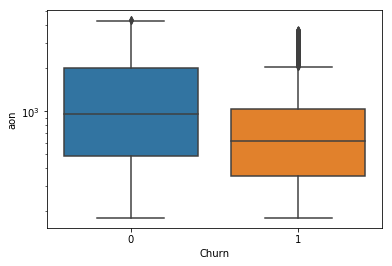

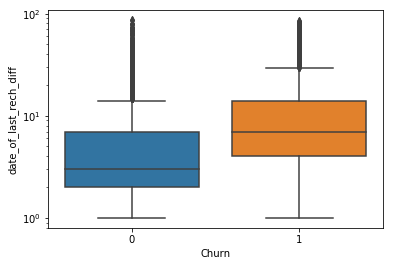

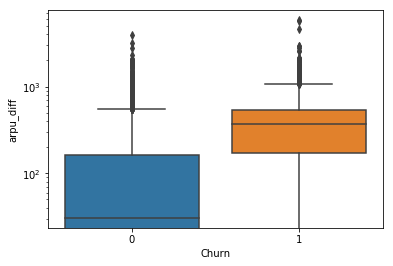

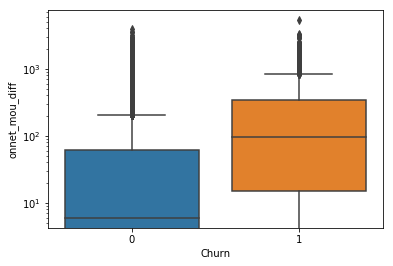

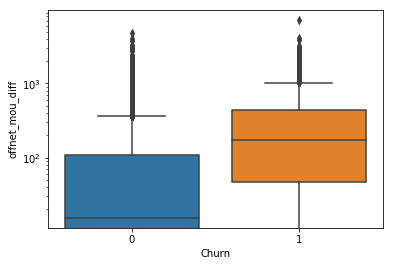

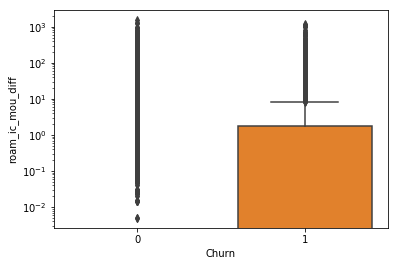

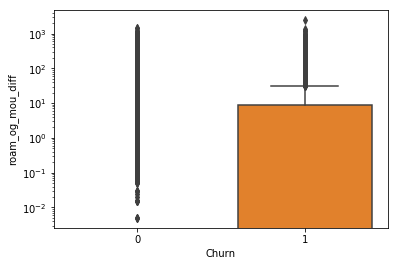

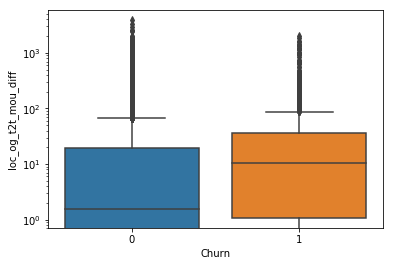

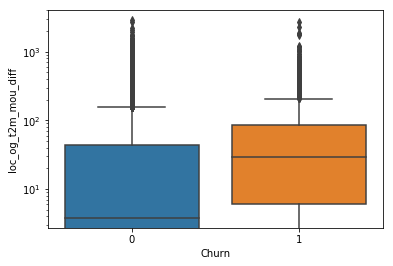

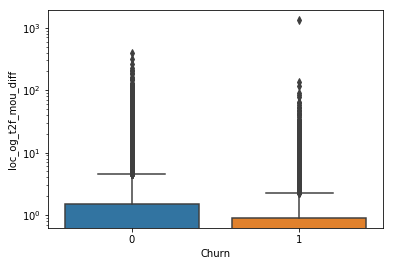

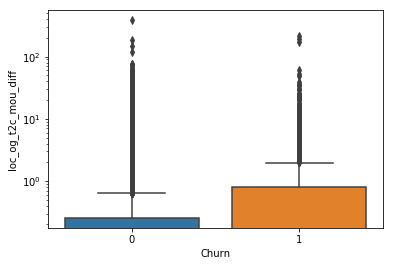

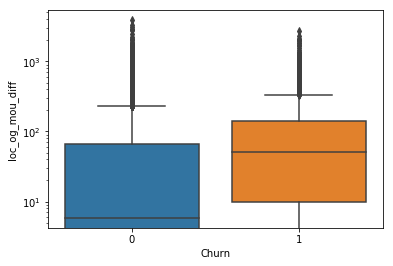

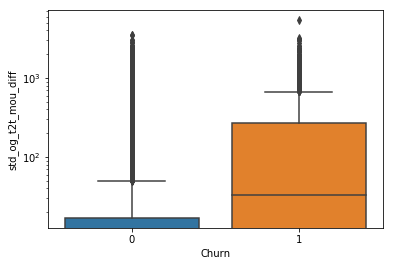

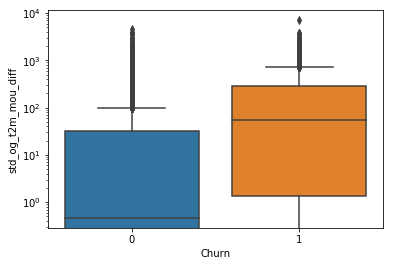

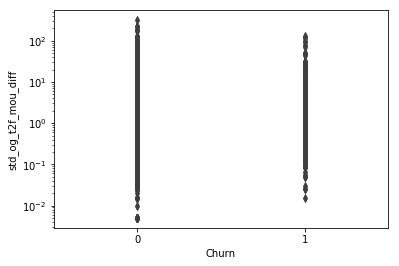

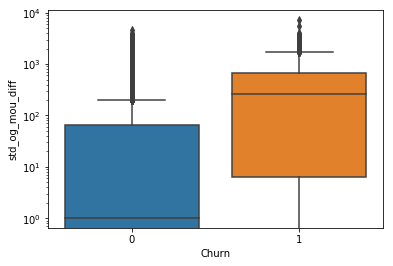

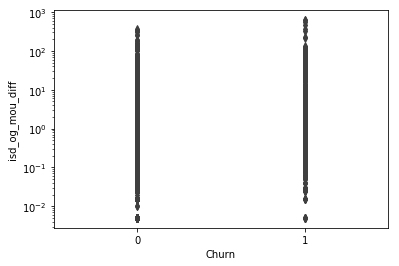

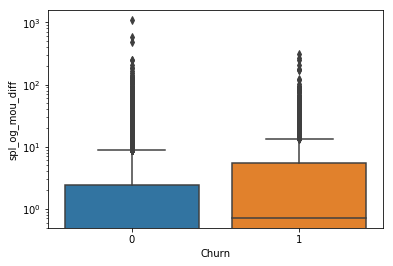

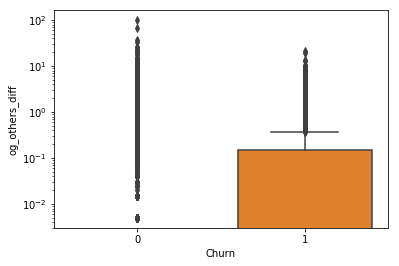

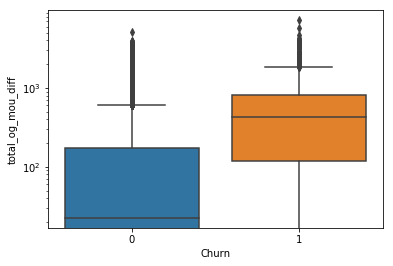

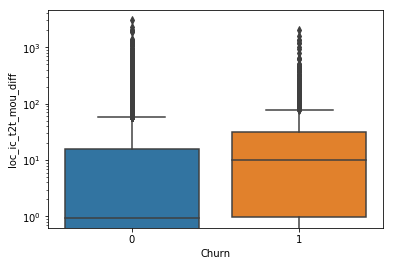

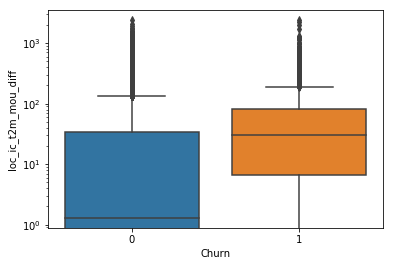

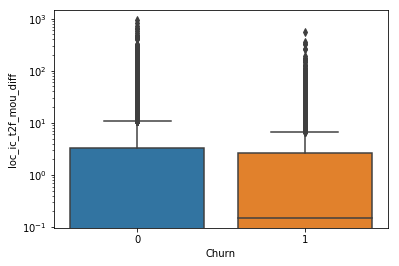

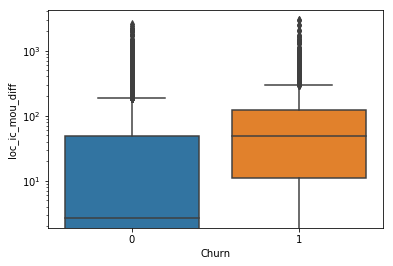

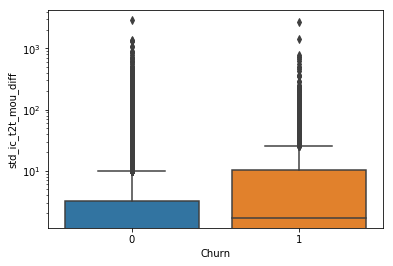

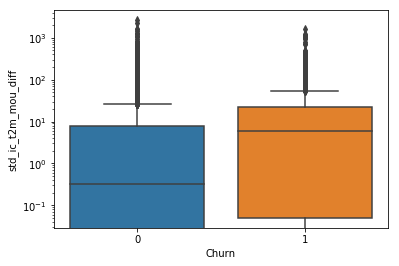

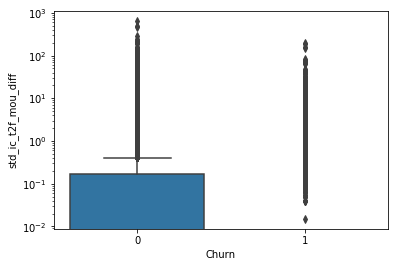

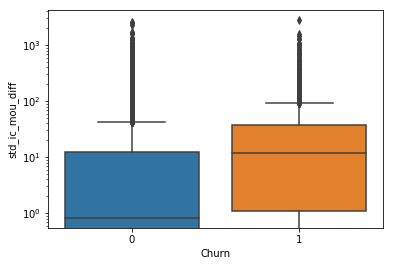

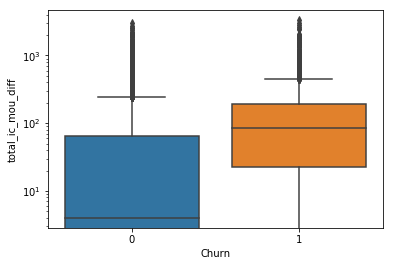

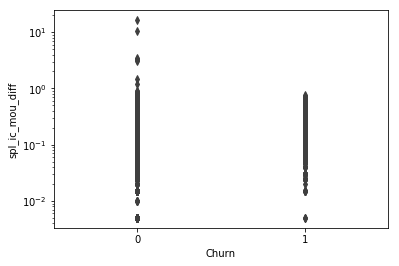

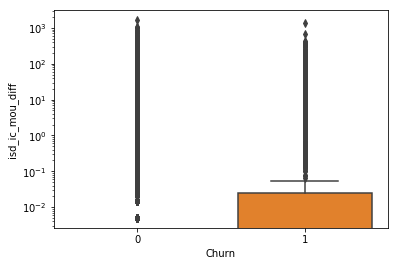

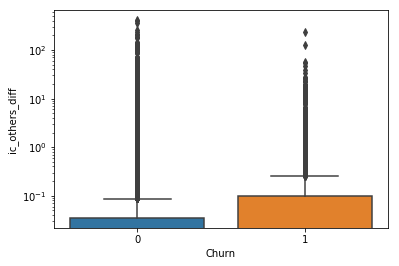

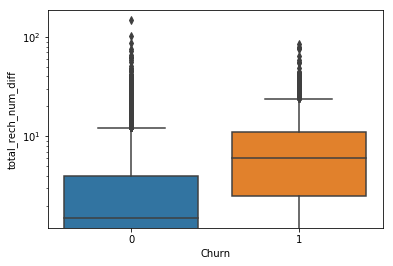

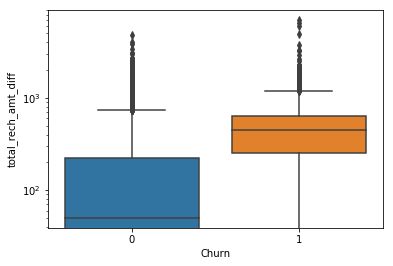

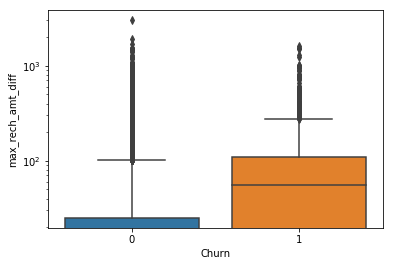

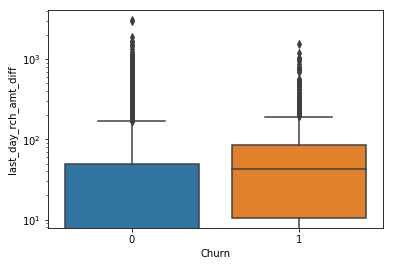

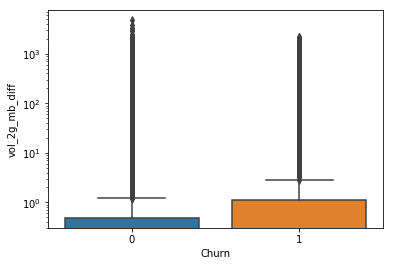

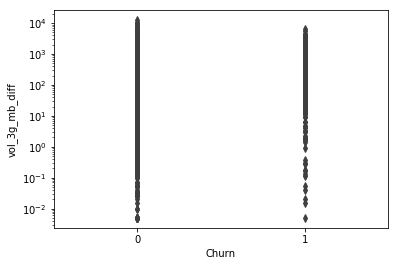

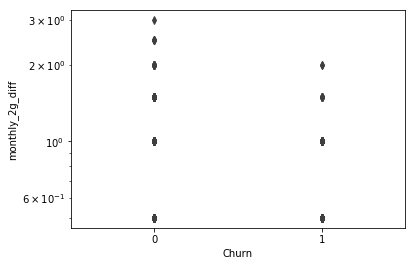

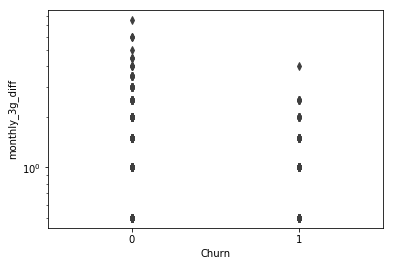

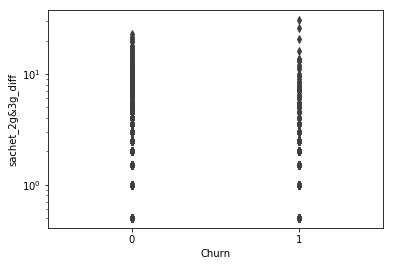

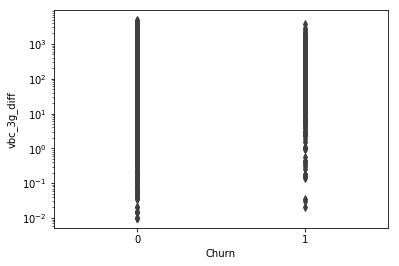

In [62]:
for col in columns:
    sns.boxplot(y=data.loc[:,col], x=data.loc[:,'Churn'])
    plt.yscale('log')
    plt.show()

We can see difference between Churn(1) and Non-churn(0) data for many columns

#####  Now let's check correlation

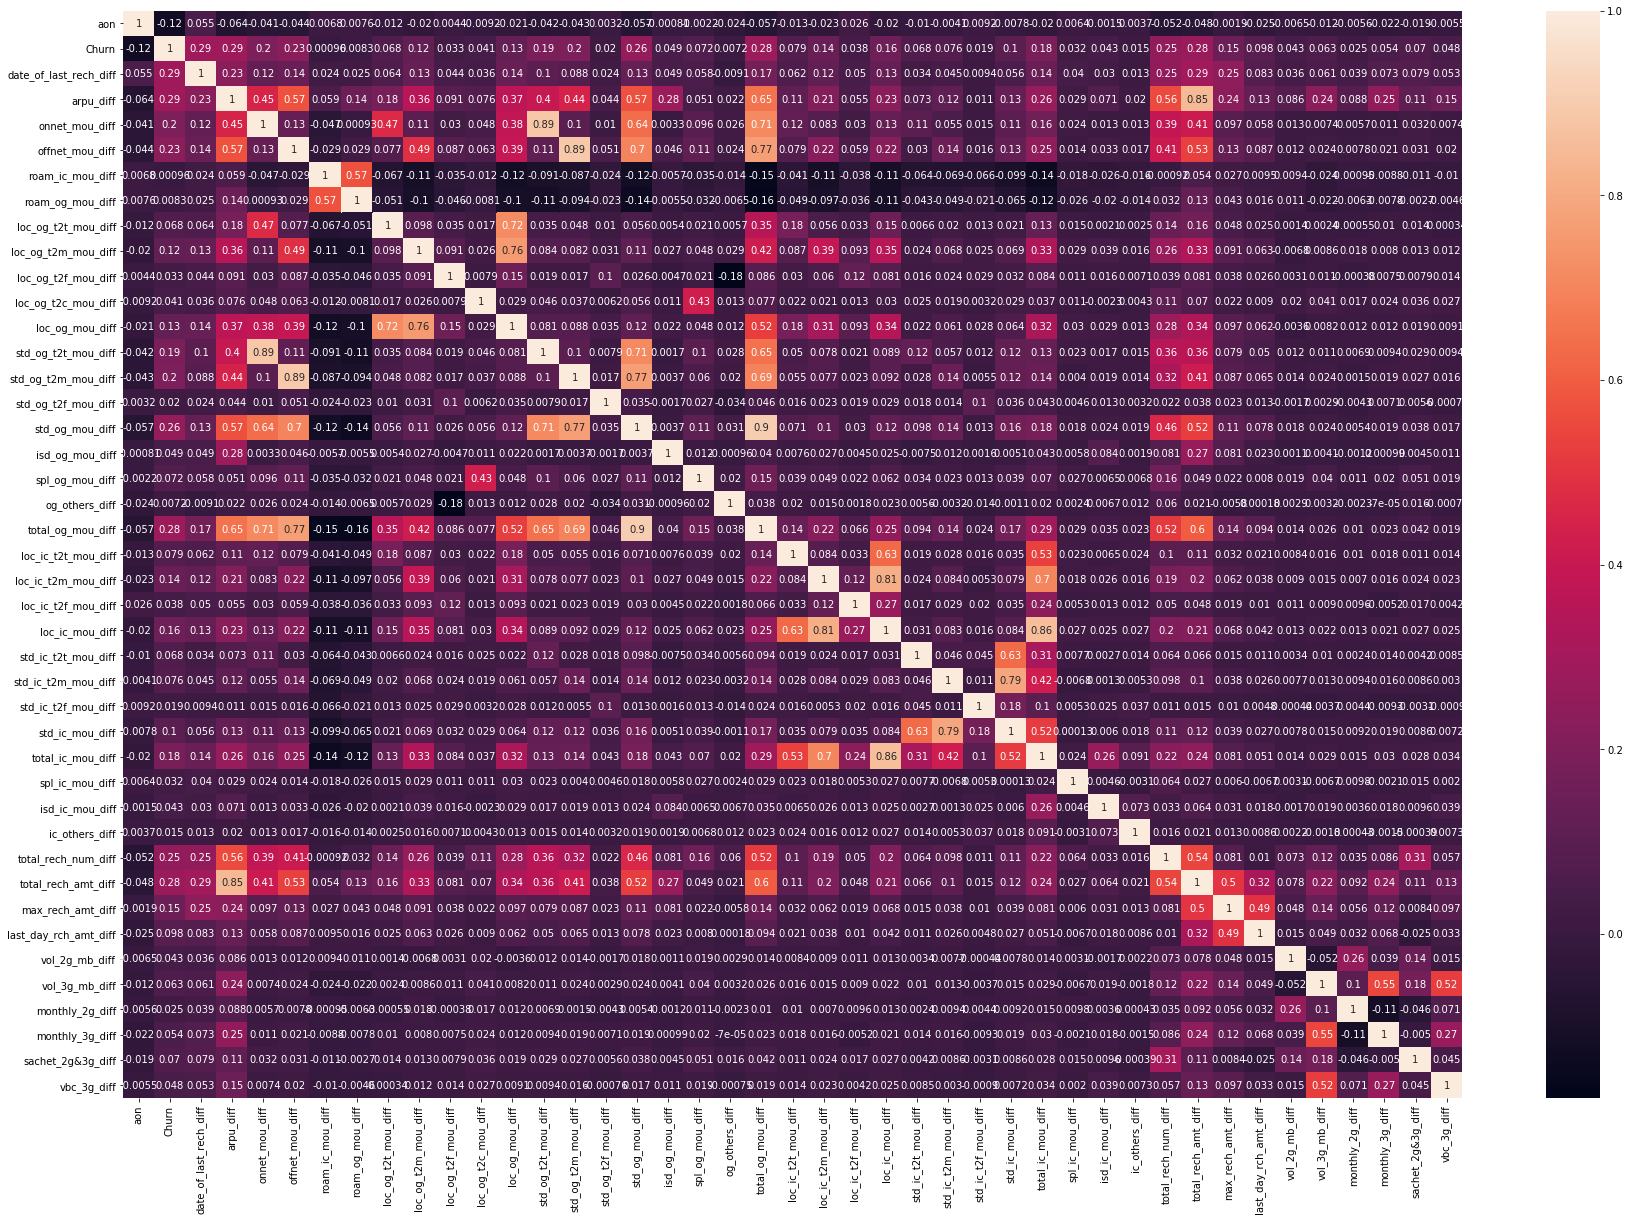

In [63]:
plt.figure(figsize=(30,20))
sns.heatmap(data.corr(), annot=True)

### Logistic regression model

In [64]:
X = data.drop('Churn', axis=1)
y = data.Churn

In [65]:
X.head()

,aon,date_of_last_rech_diff,arpu_diff,onnet_mou_diff,offnet_mou_diff,roam_ic_mou_diff,roam_og_mou_diff,loc_og_t2t_mou_diff,loc_og_t2m_mou_diff,loc_og_t2f_mou_diff,...,total_rech_num_diff,total_rech_amt_diff,max_rech_amt_diff,last_day_rch_amt_diff,vol_2g_mb_diff,vol_3g_mb_diff,monthly_2g_diff,monthly_3g_diff,sachet_2g&3g_diff,vbc_3g_diff
0,802,6,-1961.9650,3.970,184.385,-6.780,-19.895,1.105,215.725,5.405,...,-2.0,-2453.0,-395.0,-779.0,0.00,0.000,0.0,0.0,0.0,-38.680
1,315,2,298.1100,347.280,-48.835,0.000,0.000,244.870,25.230,0.000,...,6.0,399.0,92.0,15.0,177.97,363.535,0.5,0.0,-2.5,495.375
2,2607,2,-244.0015,-229.165,-216.165,11.775,20.180,-8.100,-195.255,-21.240,...,-6.0,-337.0,-20.0,80.0,-0.02,0.000,0.0,0.0,-3.0,0.000
3,511,18,177.5280,-8.350,100.255,1.415,8.870,-13.495,81.360,-8.020,...,6.0,299.0,-20.0,-30.0,0.00,0.000,0.0,0.0,0.0,12.170
4,667,7,328.9950,589.805,25.280,-2.430,-9.110,19.495,29.270,0.000,...,6.5,378.0,25.0,15.0,0.00,0.000,0.0,0.0,0.0,0.000


In [66]:
y.head()

0    1
1    0
2    0
3    0
4    0
Name: Churn, dtype: int64

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.75, random_state=100,)

In [68]:
X_train.shape

(22461, 42)

In [69]:
y_train.shape

(22461,)

In [70]:
y_train.sum()/len(y_train)

0.08597123903655225

In [71]:
y_test.sum()/len(y_test)

0.0860042735042735

In [72]:
weights = {0:0.086, 1:0.914}

In [73]:
# Standardizing the data
scaler = StandardScaler()

In [74]:
X_train_scaler = scaler.fit_transform(X_train)

In [75]:
X_train_scaler = pd.DataFrame(X_train_scaler, columns=X.columns)

In [76]:
X_train_scaler.head()

,aon,date_of_last_rech_diff,arpu_diff,onnet_mou_diff,offnet_mou_diff,roam_ic_mou_diff,roam_og_mou_diff,loc_og_t2t_mou_diff,loc_og_t2m_mou_diff,loc_og_t2f_mou_diff,...,total_rech_num_diff,total_rech_amt_diff,max_rech_amt_diff,last_day_rch_amt_diff,vol_2g_mb_diff,vol_3g_mb_diff,monthly_2g_diff,monthly_3g_diff,sachet_2g&3g_diff,vbc_3g_diff
0,-0.821098,0.935813,0.126196,-0.168170,-0.023820,-0.031550,-0.038387,-0.207159,-0.014184,1.710724,...,0.031923,-0.857278,-0.598113,-2.868803,0.013861,0.308889,-0.048643,-0.011859,0.034983,0.396328
1,1.765113,1.328661,-2.507224,-1.599766,-1.035278,-0.031550,-0.038387,-1.708885,-1.393029,-3.340122,...,-0.399370,-0.752083,-2.989448,-2.809027,-0.032609,0.008215,-0.048643,-0.011859,0.321335,0.006995
2,0.924543,-0.504627,-0.502977,-0.334673,-0.623868,-0.031550,-0.038387,-0.569410,-1.296863,0.047132,...,-0.255606,-0.504290,-0.083286,0.925227,-0.046312,0.008215,-0.048643,-0.011859,0.034983,0.006995
3,0.006162,-0.635576,-0.117906,0.175477,-0.002522,-0.031550,-0.038387,-0.150234,-0.079048,0.035118,...,0.031923,-0.415458,-0.374275,-0.484788,-0.046312,0.008215,-0.048643,-0.011859,0.034983,0.006995
4,-0.829288,0.150118,0.005957,0.299176,0.387908,-0.052284,-0.443711,-0.044505,-0.047451,-0.035965,...,0.319452,0.354805,-0.232511,-0.210521,-0.046312,0.008215,-0.048643,-0.011859,0.034983,0.006995


In [77]:
X_test_scaler = scaler.transform(X_test)

In [78]:
X_test_scaler = pd.DataFrame(X_test_scaler, columns=X.columns)

In [79]:
model = LogisticRegression(class_weight = weights)

In [80]:
model.fit(X_train_scaler, y_train)

LogisticRegression(class_weight={0: 0.086, 1: 0.914})

In [81]:
y_train_pred = model.predict(X_train_scaler)

In [82]:
confusion = metrics.confusion_matrix(y_train, y_train_pred)
confusion

array([[16908,  3622],
       [  461,  1470]], dtype=int64)

In [83]:
metrics.accuracy_score(y_train, y_train_pred)

0.818218244957927

In [84]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [85]:
y_train_prob = model.predict_proba(X_train_scaler)

In [86]:
y_train_prob

array([[0.62390797, 0.37609203],
       [0.95903059, 0.04096941],
       [0.82668523, 0.17331477],
       ...,
       [0.88127114, 0.11872886],
       [0.45942904, 0.54057096],
       [0.89506545, 0.10493455]])

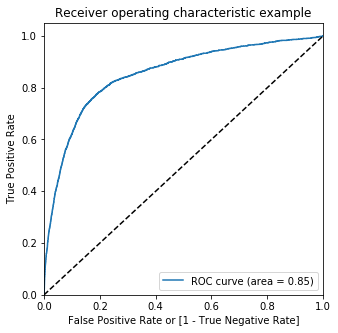

In [87]:
draw_roc(y_train, y_train_prob[:,1])

In [88]:
y_test_pred = model.predict(X_test_scaler)

In [89]:
metrics.confusion_matrix(y_test, y_test_pred)

array([[5601, 1243],
       [ 138,  506]], dtype=int64)

In [90]:
metrics.accuracy_score(y_test, y_test_pred)

0.8155715811965812

In [91]:
metrics.recall_score(y_test, y_test_pred)

0.7857142857142857

In [92]:
metrics.precision_score(y_test, y_test_pred)

0.2893081761006289

### Let's do the PCA and then create a model

In [93]:
pca = PCA(random_state=100)

In [94]:
pca.fit(X_train_scaler)

PCA(random_state=100)

In [95]:
pca.components_

array([[ 2.78534518e-02, -1.16826751e-01, -3.03866219e-01, ...,
        -5.25421310e-02, -4.42865006e-02, -3.62241618e-02],
       [-1.54407909e-02,  4.00138525e-03,  1.48181452e-01, ...,
         6.41150137e-02,  3.59514687e-02,  4.39745966e-02],
       [-1.30351375e-02, -1.57366076e-01, -1.75713323e-01, ...,
        -3.66936253e-01, -1.10348809e-01, -3.33368948e-01],
       ...,
       [ 4.92668338e-08,  1.23951174e-07,  3.74812166e-07, ...,
        -4.10647739e-09, -3.84932054e-07, -5.05782872e-08],
       [ 5.21931040e-07, -4.81853824e-07, -1.64643915e-06, ...,
         2.39455183e-07,  2.07730618e-07, -7.63021962e-08],
       [ 2.21546087e-08,  1.17213839e-08, -8.03169270e-08, ...,
         3.41220589e-08,  5.02428657e-09, -6.78692441e-09]])

Let's see the variance explained by each component

In [96]:
pca.explained_variance_ratio_

array([1.57479761e-01, 6.97285912e-02, 5.42740736e-02, 5.00576421e-02,
       4.29332759e-02, 4.01089357e-02, 3.70628166e-02, 3.50034036e-02,
       3.35630021e-02, 3.08837400e-02, 2.98588777e-02, 2.80923019e-02,
       2.69967317e-02, 2.56085159e-02, 2.50054089e-02, 2.48161722e-02,
       2.44436005e-02, 2.36676738e-02, 2.25815235e-02, 2.23596443e-02,
       2.11623430e-02, 2.07918971e-02, 2.00806761e-02, 1.91266976e-02,
       1.84393297e-02, 1.68235059e-02, 1.55969180e-02, 1.39086896e-02,
       1.15795130e-02, 1.15259000e-02, 1.02499027e-02, 6.99311730e-03,
       6.42811096e-03, 2.53654935e-03, 2.24821710e-04, 6.33587502e-06,
       3.96063600e-11, 2.30315124e-11, 1.20940454e-11, 1.10139055e-11,
       3.28654340e-12, 1.49847109e-12])

In [97]:
var_cum = np.cumsum(pca.explained_variance_ratio_)

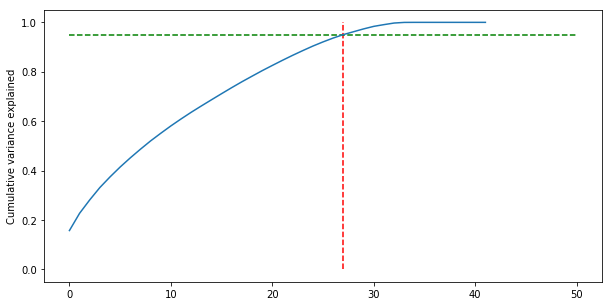

In [98]:
plt.figure(figsize=(10,5))
plt.vlines(x=27, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.95, xmax=50, xmin=0, colors="g", linestyles="--")
plt.plot(var_cum)
plt.ylabel("Cumulative variance explained")
plt.show()

27 componenets seems to explaning 95% variance of data, so let's create a new model with these top 31 components

In [99]:
pca_final = IncrementalPCA(n_components=27)

In [100]:
X_train_pca = pca_final.fit_transform(X_train_scaler)

In [101]:
corrMat = np.corrcoef(X_train_pca.transpose())

In [102]:
corrMat.shape

(27, 27)

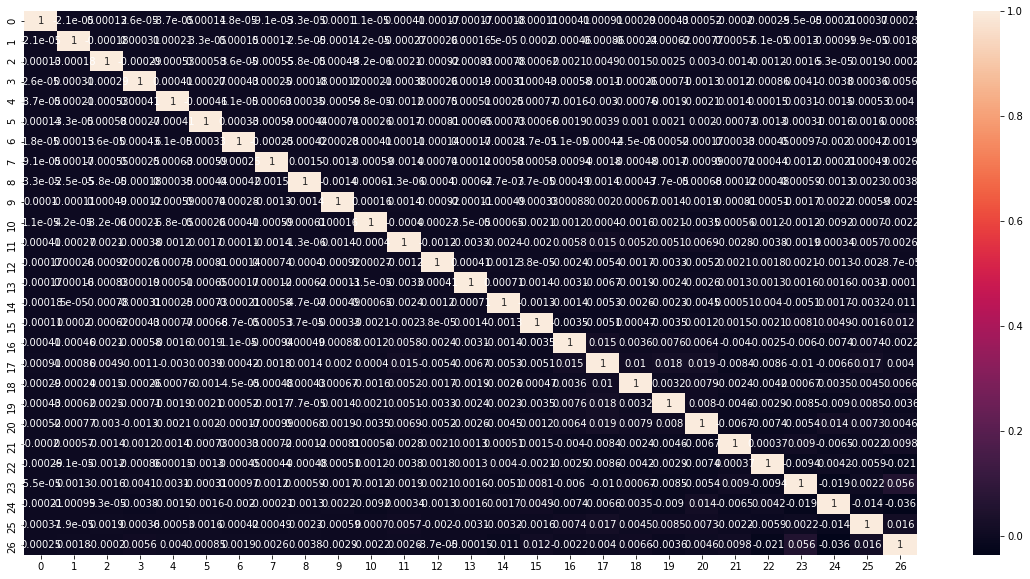

In [103]:
# Let's look at the correlation between the principle components
plt.figure(figsize=(20,10))
sns.heatmap(corrMat, annot=True)

Now let's create a logistic model with these principle components which are non correlated and also have the most of the variance of the original data

In [104]:
X_train_pca.shape

(22461, 27)

In [105]:
model = LogisticRegression(class_weight = weights)

In [106]:
model.fit(X_train_pca, y_train)

LogisticRegression(class_weight={0: 0.086, 1: 0.914})

In [107]:
# Training accuracy
y_train_pca_pred = model.predict(X_train_pca)

In [108]:
metrics.accuracy_score(y_train, y_train_pca_pred)

0.8171942478073104

In [109]:
metrics.confusion_matrix(y_train, y_train_pca_pred)

array([[16879,  3651],
       [  455,  1476]], dtype=int64)

Let's find accuracy on the testing data

In [110]:
X_test_pca = pca_final.transform(X_test_scaler)

In [111]:
y_test_pca_pred = model.predict(X_test_pca)

In [112]:
metrics.accuracy_score(y_test, y_test_pca_pred)

0.8155715811965812

In [113]:
metrics.confusion_matrix(y_test, y_test_pca_pred)

array([[5597, 1247],
       [ 134,  510]], dtype=int64)

In [114]:
metrics.recall_score(y_test, y_test_pca_pred)

0.7919254658385093

In [115]:
metrics.precision_score(y_test, y_test_pca_pred)

0.29026750142287994

## Decision Tree

In [116]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import tree

In [117]:
# parameters to build the model on
parameters = {'max_depth': range(3, 20)}

# instantiate the model
decision_tree = DecisionTreeClassifier(criterion = "gini", random_state = 100, class_weight = weights)

# fit tree on training data
grid_search = GridSearchCV(decision_tree,
                    parameters, 
                    cv = 5, 
                   scoring = "accuracy",
                   return_train_score = True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight={0: 0.086, 1: 0.914},
                                              random_state=100),
             param_grid={'max_depth': range(3, 20)}, return_train_score=True,
             scoring='accuracy')

In [118]:
# scores of GridSearch CV
scores = grid_search.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.813205,0.461159,0.014592,0.008807,3,{'max_depth': 3},0.812375,0.812778,0.826803,0.809662,...,0.818931,0.009249,17,0.818010,0.813123,0.838889,0.805331,0.832601,0.821591,0.012404
1,1.144988,0.376868,0.012003,0.001998,4,{'max_depth': 4},0.821055,0.818344,0.816118,0.829029,...,0.825654,0.010034,15,0.829697,0.815794,0.831821,0.838889,0.847738,0.832788,0.010583
2,1.572403,0.495664,0.026001,0.019320,5,{'max_depth': 5},0.833074,0.829252,0.810329,0.817008,...,0.824139,0.008889,16,0.842498,0.832545,0.831543,0.826980,0.838388,0.834391,0.005443
3,1.645606,0.856617,0.013793,0.006596,6,{'max_depth': 6},0.835522,0.839492,0.839492,0.821460,...,0.835938,0.007689,14,0.850067,0.851689,0.864322,0.840837,0.858423,0.853068,0.007948
4,1.617427,0.658236,0.017794,0.011522,7,{'max_depth': 7},0.853995,0.817231,0.849065,0.835485,...,0.838965,0.012747,13,0.871104,0.835272,0.876676,0.856308,0.854861,0.858844,0.014465


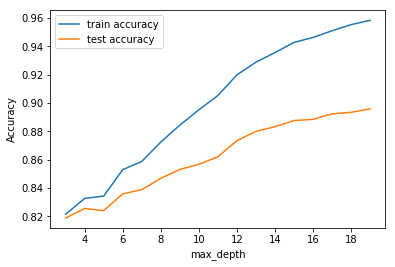

In [119]:
# plotting accuracies with max_depth
plt.figure()
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="train accuracy")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [120]:
# Fitting the decision tree with max depth 15
decision_tree = DecisionTreeClassifier(max_depth=15, class_weight = weights)
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 0.086, 1: 0.914}, max_depth=15)

In [121]:
y_train_pred = decision_tree.predict(X_train)

In [122]:
metrics.confusion_matrix(y_train, y_train_pred)

array([[19031,  1499],
       [   28,  1903]], dtype=int64)

In [123]:
# Making predictions
y_test_pred = decision_tree.predict(X_test)

In [124]:
metrics.confusion_matrix(y_test, y_test_pred)

array([[6121,  723],
       [ 177,  467]], dtype=int64)

In [125]:
metrics.recall_score(y_test, y_test_pred)

0.7251552795031055

In [126]:
metrics.precision_score(y_test, y_test_pred)

0.39243697478991596

### Random Forest

In [127]:
from sklearn.ensemble import RandomForestClassifier

In [128]:
# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(2, 20, 2)}

# instantiate the model
randomForest = RandomForestClassifier()


# fit tree on training data
gridSearch = GridSearchCV(randomForest,
                  parameters, 
                  cv=n_folds, 
                  scoring="accuracy",
                  return_train_score=True)
gridSearch.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': range(2, 20, 2)}, return_train_score=True,
             scoring='accuracy')

In [129]:
# scores of GridSearch CV
scores = gridSearch.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,7.247986,1.371251,0.199007,0.036838,2,{'max_depth': 2},0.913866,0.914069,0.914069,0.914069,...,0.914029,0.000081,9,0.914069,0.914019,0.914019,0.914019,0.914019,0.914029,0.000020
1,12.289008,1.085392,0.286192,0.235866,4,{'max_depth': 4},0.915647,0.917631,0.920080,0.919190,...,0.918169,0.001508,8,0.921972,0.917191,0.920085,0.919918,0.917692,0.919371,0.001741
2,17.716614,1.202346,0.273798,0.059713,6,{'max_depth': 6},0.924549,0.929207,0.930098,0.928094,...,0.928721,0.002389,7,0.934550,0.933107,0.932217,0.933385,0.932495,0.933151,0.000815
3,19.426196,2.838515,0.329782,0.120605,8,{'max_depth': 8},0.927220,0.932769,0.934996,0.932102,...,0.932016,0.002585,6,0.943232,0.942067,0.943736,0.943180,0.941677,0.942779,0.000775
4,17.984620,4.652915,0.203783,0.068797,10,{'max_depth': 10},0.928778,0.935886,0.936776,0.930766,...,0.933485,0.003135,5,0.956089,0.956481,0.955368,0.954922,0.955535,0.955679,0.000548


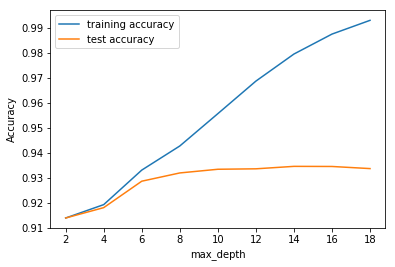

In [130]:
# plotting accuracies with max_depth
plt.figure()
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Creating random forest

In [131]:
# Running the random forest with max depth 8
randomForest = RandomForestClassifier(max_depth=8, class_weight=weights)

randomForest.fit(X_train,y_train)

RandomForestClassifier(class_weight={0: 0.086, 1: 0.914}, max_depth=8)

In [132]:
y_train_pred = randomForest.predict(X_train)

In [133]:
metrics.confusion_matrix(y_train, y_train_pred)

array([[18961,  1569],
       [  226,  1705]], dtype=int64)

In [134]:
# Making predictions on testing data
y_test_pred = randomForest.predict(X_test)

In [135]:
metrics.confusion_matrix(y_test, y_test_pred)

array([[6252,  592],
       [ 140,  504]], dtype=int64)

In [136]:
metrics.recall_score(y_test, y_test_pred)

0.782608695652174

In [137]:
metrics.precision_score(y_test, y_test_pred)

0.45985401459854014

### Model to be used to detect the churn
The performance of random forest is better than the logistic regression, and decision tree models for the given data hence we can use random forest to detect the consumer who are going to churn.
The recall rate and precision rate for the random forest is the highest than the other two models which shows that it is going to detect most of the consumer who are going to chur with less percentage of wrong prediction compratively to the other two models.

### Identify the most important variable to detect the churn

In [ ]:
# Only drawing the top part of the decision tree model trained above to know the important variables
fn=X_train.columns
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (20,20), dpi=400)
tree.plot_tree(decision_tree, feature_names = fn, filled = True, max_depth=4, fontsize=15);
fig.savefig('topOfDecisionTree.png')

If we look at the decision above for the given data set, we can observed that the most important variables(factors) to identify if a conumer will churn or not are the significance difference in the following variables from good state to action state<br>
1 ) arpu (Average revenue per user) <br>
2 ) roam_og_mou (Minutes of outgoing call in roaming state) <br>
3 ) loc_ic_mou (Minutes of local incoming call )<br>
4 ) vol_3g_mb (3g data volume used)<br>
5 ) date_last_rech (days since the user has recharged their mobile)<br>
6 ) roam_og_mou (Minutes of outgoing call in roaming state)<br>